In [4]:
!pip install joblib

    100% |████████████████████████████████| 286kB 27.6MB/s ta 0:00:01


In [5]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib


### Part 1  prepare for training data 

In [6]:
ibc_df = pd.read_csv('/home/jovyan/work/Model_Training_Data/IBC_data_260319_1.csv')
print(len(ibc_df))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


419262


In [7]:
ibc_df['deleted_reason'].unique()

array([nan, 'not_doctors_note', 'phoneORaddressORother_number',
       'not_relevant', 'preventative_screening', 'negation', 'other',
       'family_history', 'incorrect_year_of_service',
       'Incorrect Specification - Non-Risk Adjusted', 'incorrect_acronym',
       'repeated_instance', 'incorrect_spec', 'medical_history',
       'incorrect_version'], dtype=object)

In [8]:
listreason=['incorrect_year_of_service','Incorrect Specification - Non-Risk Adjusted','repeated_instance', 'incorrect_spec']

In [9]:
ibc_df=ibc_df[ibc_df['deleted_reason'].isin(listreason)== False]
ibc_df['deleted_reason'].unique()

array([nan, 'not_doctors_note', 'phoneORaddressORother_number',
       'not_relevant', 'preventative_screening', 'negation', 'other',
       'family_history', 'incorrect_acronym', 'medical_history',
       'incorrect_version'], dtype=object)

In [10]:
list1=ibc_df['chart_id'].unique()
print(len(list1))   # 
print(len(set(list1)))  # number of unique charts in this dataset

41025
41025


In [11]:
# doing some preprocessing or cleaning punctuation and stop words
ibc_df= ibc_df.replace(np.nan,'',regex = True)
print(len(ibc_df))

367451


In [12]:
trainDF=ibc_df
trainDF['text75'] = trainDF['75char']
trainDF = trainDF[pd.notnull(trainDF['text75'])]
print(len(trainDF))

367451


In [13]:
import string
trainDF['cleaned_data'] = trainDF['text75'].apply(lambda x: x.lower())
trainDF['cleaned_data'] = trainDF['cleaned_data'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))

In [14]:
nltk.download('stopwords')
stop = stopwords.words('english')

trainDF['cleaned_data']= trainDF['cleaned_data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
trainDF['cleaned_data']=trainDF['cleaned_data'].str.findall('\w{2,}').str.join(' ')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
trainDF.head()

,Unnamed: 0,chart_id,code_id,text,start_offset,end_offset,deleted_reason,deleted,label,15char,25char,50char,75char,10word_after,10word_before,50word_after,50word_before,flag,text75,cleaned_data
0,0,002803945_161667176A_2016_001,E6601,e66.01,14251,14257,,,agreed,cess calories (E66.01).,due to excess calories (E66.01). ...,sessment Morbid obesity due to excess calori...,.7). Assessment Morbid obe...,"[[').', 'Assessment', 'Traumatic', 'brain', 'i...","[['Fibromyalgia', '(M79.7).', 'Assessment', 'M...","[[').', 'Assessment', 'Traumatic', 'brain', 'i...","[['Assessment/Plan', '#', 'Detail', 'Type', 'D...",0,.7). Assessment Morbid obe...,assessment morbid obesity due excess calories ...
1,1,002803945_161667176A_2016_001,E6601,e66.01,22445,22451,,,agreed,cess calories (E66.01). Impre,due to excess calories (E66.01). Impre...,sessment Morbid obesity due to excess calori...,ise. Assessment Morbid obe...,"[[').', 'Impression', 'encouraged', 'to', 'die...","[['-diet', 'exercise.', 'Assessment', 'Morbid'...","[[').', 'Impression', 'encouraged', 'to', 'die...","[['Impression', 'seeing', 'pain', 'management,...",0,ise. Assessment Morbid obe...,ise assessment morbid obesity due excess calor...
2,2,002803945_161667176A_2016_001,E789,e78.9,14501,14506,,,agreed,m cholesterol (E78.9).,vated serum cholesterol (E78.9). ...,Assessment Elevated serum cholester...,izures (F44.5). Assessment ...,"[[').', 'Assessment', 'Anxiety', '(F41.9).', '...","[['sequela', '(S06.9X9S).', 'Assessment', 'Pse...","[[').', 'Assessment', 'Anxiety', '(F41.9).', '...","[['chronic', 'depression--multitude', 'sx', 's...",0,izures (F44.5). Assessment ...,izures f445 assessment elevated serum choleste...
3,3,002803945_161667176A_2016_001,F329,f32.9,21557,21562,,,agreed,"sion, chronic (F32.9). Impression","jor depression, chronic (F32.9). Impressions...","ad injury. AssessmentMajor depression, chron...","etter w meds, flared w head injury. Assessme...","[[').', 'Impressionstable,', 'cont', 'Rx.', 'A...","[['w', 'meds,', 'flared', 'w', 'head', 'injury...","[[').', 'Impressionstable,', 'cont', 'Rx.', 'A...","[['accupuncturist,pain', 'management.', 'Asses...",0,"etter w meds, flared w head injury. Assessme...",etter meds flared head injury assessmentmajor ...
4,4,002803945_161667176A_2016_001,F329,Major depression,17574,17590,,,agreed,"pap finding Major depression,08/10/2016 ch","abnormal pap finding Major depression,08/1...",:00 PM 3/36 unspecified abnormal pap findin...,07/28/1977 09/19/2016 06:00 PM 3/36 unspeci...,"[[',08/10/2016', 'chronic', 'Left-sided', 'wea...","[['I.', '07/28/1977', '09/19/2016', '06:00', '...","[[',08/10/2016', 'chronic', 'Left-sided', 'wea...","[['on', '05/04/2014.', 'Hallucination', '08/10...",0,07/28/1977 09/19/2016 06:00 PM 3/36 unspeci...,07281977 09192016 0600 pm 336 unspecified abno...


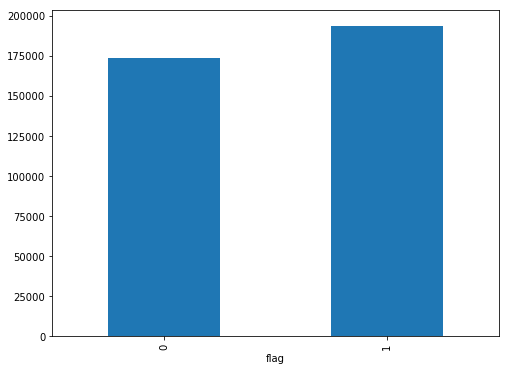

flag
0    173651
1    193800
dtype: int64

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
trainDF.groupby('flag').flag.count().plot.bar(ylim=0)
plt.show()
trainDF.groupby(['flag']).size()                 # 0 is agreed+added, 1 is deleted 

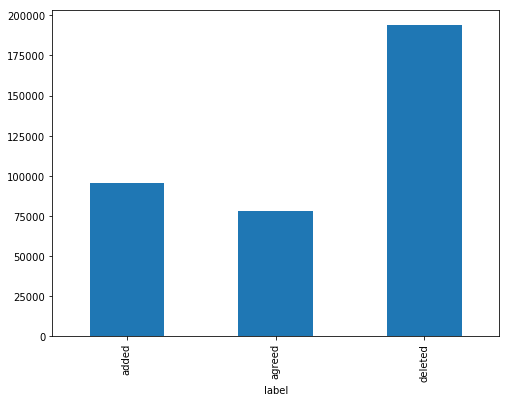

label
added       95563
agreed      78088
deleted    193800
dtype: int64

In [17]:
fig = plt.figure(figsize=(8,6))
trainDF.groupby('label').flag.count().plot.bar(ylim=0)
plt.show()
trainDF.groupby(['label']).size()  

In [73]:
'''
# randomly generate  a list 
import random
save4testibclist = random.sample(set(list1), 2000)  # set aside 2000 charts for testing
train_df_4test = trainDF[trainDF['chart_id'].isin(save4testibclist)]
print(len(train_df_4test))
train_df_4train = trainDF[trainDF['chart_id'].isin(save4testibclist)== False]
print(len(train_df_4train))
'''

18127
349324


In [110]:
'''
print(save4testibclist)
'''

['IBXRMA2018_MULT_1216758780010001_HMK_226380918A_JUANITA_HUFFMAN_002821294_2017', 'IBXRMA2018_MULT_1254954930010001_HMK_246463926D2_GLADYS_CHANNELL_002805322_2017', 'IBXRMA2018_MULT_1217830920010001_HMK_342367786A_MARLENE_BAGNULL_002811508_2017', 'IBXRMA2018_MULT_1253367080010002_HMK_189401272A_ELEANOR_PEREIRA_002805178_2017', 'IBXRMA2018_MULT_1207317550010001_HMK_185289449A_HENRY_MIOSKIE_002811377_2017_pmh', 'IBXRMA2018_MULT_1217830140010001_HMK_187246027A_MILDRED_MINSTER_003061466_2017_20180529105848', 'IBXRMA2018_MULT_1221276150010001_HMK_167625202A_JODIE_ROCCO_002807673_2017', 'IBXRMA2018_MULT_1216904610010001_HMK_178345518D_LUCY_ROSENBERGER_002809074_2017', 'IBXRMA2018_MULT_1216863920010001_HMK_193323160A_FRANCES_CAHILL_002811552_2017_20180517111958', 'IBXRMA2018_MULT_1216933150010001_HMK_185422063A_JOANNE_MATURO_002804973_2017', 'ibxrma2018_mult_1216986020010001_hmk_197105254d_phyllis_teti_002808236_2017', 'IBXRMA2018_MULT_1205167390010001_HMK_160660206A_CHRISTINE_OBST_002804524

In [111]:
'''
datalist = ','.join(save4testibclist)
fh = open('save4testibclistlstm.csv', 'w+')
fh.write(datalist)
fh.close()
'''

In [36]:
train_df_4train=pd.read_csv("ibc_trainingdata_040219.csv")
train_df_4test=pd.read_csv("ibc_testingdata_040219.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
col = ['cleaned_data','flag']
testDF = train_df_4test[col]   #used for independent testing
testnDF = testDF[pd.notnull(testDF['cleaned_data'])]
testDF.columns = ['text75','flag']
trainDF1 = train_df_4train[col] # used for training and validation
trainDF1 = trainDF1[pd.notnull(trainDF1['cleaned_data'])]
trainDF1.columns = ['text75','flag']

In [38]:
trainDF1.head()

,text75,flag
0,assessment morbid obesity due excess calories ...,0
1,ise assessment morbid obesity due excess calor...,0
2,izures f445 assessment elevated serum choleste...,0
3,etter meds flared head injury assessmentmajor ...,0
4,07281977 09192016 0600 pm 336 unspecified abno...,0


In [39]:
testDF.head()

,text75,flag
0,disorder z720 obstructive chronic bronchitis a...,0
1,initis j310 cough r05 esophageal reflux k219 h...,0
2,initis j310 cough r05 esophageal reflux k219 h...,0
3,yperlipidemia e785 mitral regurgitation 1340 m...,0
4,yperlipidemia e785 mitral fegurgithtion 1340 m...,0


### Part 2. Preparing data, word tokenizing

####  word tokenizing first

In [24]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

Using TensorFlow backend.


In [25]:
trainDF1.flag.value_counts()

1    184287
0    164980
Name: flag, dtype: int64

####  This is to use only trainDFsel for tokenizer, then generate the sequence on testDF, just to compare if the tokenizer can generate similar sequences, if not, there is an issue, because for unseen data, the tokenizer is not working as expected

In [26]:
# this is using only training data  to generate tockenizer, 
n_most_common_words = 100000
max_len = 70
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
#tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(trainDF1['text75'].values)
sequences = tokenizer.texts_to_sequences(trainDF1['text75'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = pad_sequences(sequences, maxlen=max_len)
word_vector = sequences[0]
print(len(word_vector))
print('Num words = {0}'.format(len(tokenizer.word_index)))
#with open("../picklefolder_ngrams/keras_tokenizer_embeddings_0328.pickle", "wb") as f:
#   pickle.dump(tokenizer, f)    # save the tokenizer as a pickle file
# save the tokenizer
#with open("../picklefolder_ngrams/keras_tokenizer_embeddings_0328.pickle", "wb") as f:
#   pickle.dump(tokenizer, f)   # this tokenizer used 4 deletion reasons

Found 265290 unique tokens.
13
Num words = 265290


In [51]:
with open("../picklefolder_ngrams/keras_tokenizer_embeddings_0328.pickle", "rb") as f:
   tokenizer = pickle.load(f)

In [11]:
# load the existing tokenizer
'''
n_most_common_words = 100000
max_len = 70
import pickle
# loading the tokenizer
with open("../picklefolder_ngrams/keras_tokenizer_embeddings_0328.pickle", "rb") as f:
   tokenizer = pickle.load(f)
'''

In [28]:
word_index

{'disease': 1,
 'hypertension': 2,
 'history': 3,
 'chronic': 4,
 'diabetes': 5,
 'unspecified': 6,
 'hyperlipidemia': 7,
 'type': 8,
 'patient': 9,
 'kidney': 10,
 'mellitus': 11,
 'without': 12,
 'essential': 13,
 'disorder': 14,
 'heart': 15,
 'stable': 16,
 'screening': 17,
 'primary': 18,
 'cancer': 19,
 'plan': 20,
 'family': 21,
 'cholesterol': 22,
 'depression': 23,
 'artery': 24,
 'current': 25,
 'stage': 26,
 'continue': 27,
 'use': 28,
 'pain': 29,
 'atrial': 30,
 'coronary': 31,
 'assessment': 32,
 'benign': 33,
 'medical': 34,
 'left': 35,
 'normal': 36,
 'onset': 37,
 'blood': 38,
 'right': 39,
 'hypercholesterolemia': 40,
 'pulmonary': 41,
 'visit': 42,
 'i10': 43,
 'diabetic': 44,
 'mild': 45,
 'fibrillation': 46,
 'active': 47,
 'osteoporosis': 48,
 'problem': 49,
 'reflux': 50,
 'hypothyroidism': 51,
 'failure': 52,
 'past': 53,
 'anxiety': 54,
 'mixed': 55,
 'care': 56,
 'problems': 57,
 'mg': 58,
 'due': 59,
 'high': 60,
 'htn': 61,
 'reviewed': 62,
 'present': 63,


In [52]:
#sequences = tokenizer.texts_to_sequences(trainDFsel['text75'].values)
#sequences = tokenizer.texts_to_sequences(trainDFsel['text75'].values)
#word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))
#Xsel = pad_sequences(sequences, maxlen=max_len)
#word_vector = sequences[0]
#print(len(word_vector))
print((X!=0).argmax(axis=0)) # find the first non zero row for each column
print(np.count_nonzero(X, axis=0))   # find the number of nonzero in each column  ok it seems it's working fine here.

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0 141873 141873 137127
  92616  83813  83813  83813  58943  38049   3280   1407   1405   1381
   1381   1381   1371   1365    567    352    352     87     33     33
     33     33     32     14     14      3      3      0      0      0
      0      0      0      0      0      0      0      0      0      0]
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      1      1      3
      7     12     17     20     27     35     58    103    171    316
    484    790   1258   1981   3122   5096   8340  13563  22754  37316
  60100  93196 136472 185382 232575 272486 301710 321093 332223 338540
 342099 344149 345457 346280 346918 347360 347727 348071 348481 349227]


In [53]:
# Training 
print(len(X))
labels=trainDF1['flag']
print(len(labels))   # these are training dataset
print(X.shape)
# below is the  testing dataset 
# 
print(len(testDF))


349267
349267
(349267, 70)
18127


In [54]:
# tokenize the test dataset
sequences = tokenizer.texts_to_sequences(testDF['text75'].values)
#word_index = tokenizer.word_index
#print('Found %s unique tokens.' % len(word_index))

testX1 = pad_sequences(sequences, maxlen=max_len)
y_test1 = testDF['flag']
print(testX1.shape,y_test1.shape)

(18127, 70) (18127,)


#### Now split train and validation data, below X_test,y_test are validation data,  X_test1 and y_test1  are independent test data not seen by the model training 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=12)

In [56]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((279413, 70), (279413,), (69854, 70), (69854,))


In [57]:
print(trainDF1['text75'][10])

unspecified duration sequela s069x9s assessment pseudoseizures f445 assessment elevated serum cholesterol e789


In [58]:
print(X_train[10])   # here one instance is still just a sequence

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0   375   316   134 18517  1708   475
  1205   222   115  5334  4721  2201  7720  4857  5422  6468]


### Part 3. Model training

In [48]:
from keras.layers import Embedding, Flatten, Dense, Input
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
#from keras.layers.embeddings import Embedding
#from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

#### A. Using CNN+LSTM

In [49]:
# this one is actually  not using pre-trained word embeddings, 
# but instead initializing the Embedding layer from scratch and learning its weights during training
batch_size=512
epochs=3
EMBEDDING_DIM=128
n_most_common_words=200000
model = Sequential()    
model.add(Embedding(n_most_common_words, EMBEDDING_DIM, input_length=max_len))
#model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=5,activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64, dropout=0.75, recurrent_dropout=0.75))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 128)           25600000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 66, 64)            41024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 25,674,113
Trainable params: 25,674,113
Non-trainable params: 0
_________

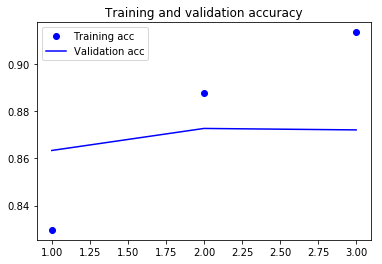

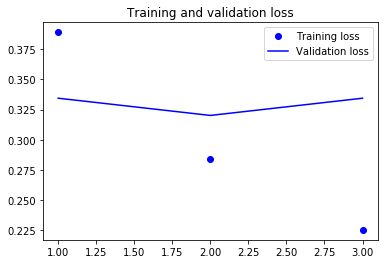

In [50]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [59]:
# use independent test dataset for evaluation
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = model.evaluate(testX1,y_test1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69854/69854 [==============================] - 11s 158us/step
Test set
  Loss: 0.334
  Accuracy: 0.872
18127/18127 [==============================] - 3s 158us/step
Test set
  Loss: 0.418
  Accuracy: 0.840


In [48]:
#joblib.dump(model, '../picklefolder_ngrams/DeleteReason_biclass_Mar2719_cnnlstm.pickle')    
#model.save('../picklefolder_ngrams/DeleteReason_biclass_Mar2719_cnnlstm_model.h5')

In [98]:
joblib.dump(model, '../picklefolder_ngrams/DeleteReason_biclass_Mar2819_cnnlstm.pickle')    
#model.save('../picklefolder_ngrams/DeleteReason_biclass_Mar2819_cnnlstm_model.h5')

['../picklefolder_ngrams/DeleteReason_biclass_Mar2819_cnnlstm.pickle']

Test accuracy is 0.8767193873899664
[[29066  3794]
 [ 4819 32186]]
Test accuracy is 0.8767193873899664
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.86      0.88      0.87     32860
          Class 1:deletion       0.89      0.87      0.88     37005

               avg / total       0.88      0.88      0.88     69865

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.816474629643 1   0.76  0.95 21738 1700 11122 35305
0.2 0.854805696701 1   0.82  0.93 25382 2666 7478 34339
0.3 0.869247835111 1   0.85  0.91 27115 3390 5745 33615
0.4 0.875016102483 1   0.88  0.89 28252 4124 4608 32881
0.5 0.87671938739 1   0.89  0.87 29066 4819 3794 32186
0.6 0.873656337222 1   0.91  0.85 29750 5717 3110 31288
0.7 0.869047448651 1   0.92  0.82 30345 6634 2515 30371
0.8 0.857611107135 1   0.94  0.78 30906 7994 1954 29011
0.9 0.832834752737 1   0.95  0.72 31573 10392 1287 26613


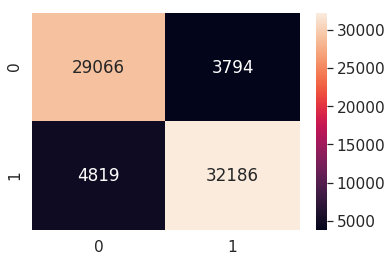

In [103]:
# testing on the testing data using split

predictiont2 = model.predict(X_test)

finallabelt2= (predictiont2 > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabelt2)))

conf_mat = confusion_matrix(y_test, finallabelt2)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabelt2)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test, finallabelt2, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2t = np.where(predictiont2 > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test, prediction2t)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test,prediction2t)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test, prediction2t),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)


Test accuracy is 0.8433827991394053
[[7178 1477]
 [1362 8110]]
Test accuracy is 0.8433827991394053
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.84      0.83      0.83      8655
          Class 1:deletion       0.85      0.86      0.85      9472

               avg / total       0.84      0.84      0.84     18127

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.765267280852 1   0.71  0.95 4914 514 3741 8958
0.2 0.808131516522 1   0.76  0.92 5966 789 2689 8683
0.3 0.827494897115 1   0.80  0.89 6529 1001 2126 8471
0.4 0.83665250731 1   0.82  0.87 6880 1186 1775 8286
0.5 0.843382799139 1   0.85  0.86 7178 1362 1477 8110
0.6 0.84619628179 1   0.87  0.83 7474 1607 1181 7865
0.7 0.844099961384 1   0.89  0.80 7702 1873 953 7599
0.8 0.837976499145 1   0.91  0.77 7939 2221 716 7251
0.9 0.816902962432 1   0.93  0.70 8180 2844 475 6628


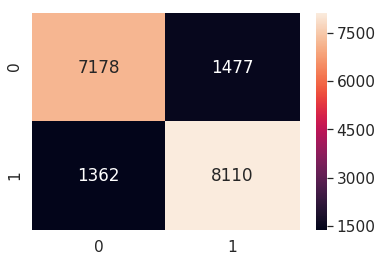

In [104]:
# testing on the set aside test data from ibc

predictiont2 = model.predict(testX1)

finallabelt2= (predictiont2 > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))

conf_mat = confusion_matrix(y_test1, finallabelt2)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test1, finallabelt2, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2t = np.where(predictiont2 > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test1, prediction2t)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test1,prediction2t)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test1, prediction2t),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)


In [109]:
testX1

array([[    0,     0,     0, ...,  6116,    82, 50240],
       [    0,     0,     0, ...,  2518,  2577,  1211],
       [    0,     0,     0, ...,  2518,  2577,  1211],
       ..., 
       [    0,     0,     0, ...,    64,   365,   583],
       [    0,     0,     0, ...,     4,   129,    41],
       [    0,     0,     0, ...,   113,    64,   365]], dtype=int32)

In [4]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

#### B. Using LSTM only

In [60]:
epochs=3
batch_siz=256
emb_dim=128
model2 = Sequential()
model2.add(Embedding(n_most_common_words, emb_dim, input_length=X_train.shape[1]))
model2.add(SpatialDropout1D(0.5))
model2.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model2.summary())
#history2 = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history3 = model2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 128)           25600000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 70, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,649,473
Trainable params: 25,649,473
Non-trainable params: 0
_________________________________________________________________
None
Train on 279413 samples, validate on 69854 samples
Epoch 1/3
279413/279413 [==============================] - 205s 735us/step - loss: 0.4420 - acc: 0.7976 - val_loss: 0.3596 - val_acc: 0.8496
Epoch 2/3
279413/279413 [==============================] - 203s 7

In [61]:
accr = model2.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = model2.evaluate(testX1,y_test1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69854/69854 [==============================] - 28s 402us/step
Test set
  Loss: 0.329
  Accuracy: 0.865
18127/18127 [==============================] - 7s 402us/step
Test set
  Loss: 0.367
  Accuracy: 0.848


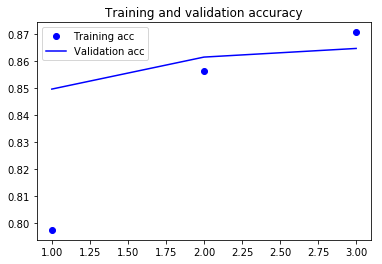

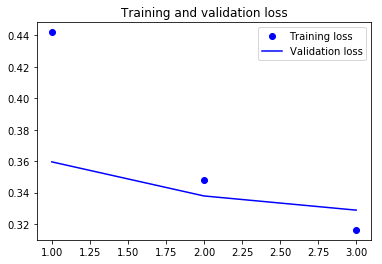

In [62]:
import matplotlib.pyplot as plt

acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [102]:
joblib.dump(model2, '../picklefolder_ngrams/DeleteReason_biclass_Mar2819_lstm.pickle')  

['../picklefolder_ngrams/DeleteReason_biclass_Mar2819_lstm.pickle']

In [63]:
# one example of prediction
txt = ['gkins diagnosed cancer brother alive stroke diagnosed stroke sister alive breast cancer diagnosed cancer sister aliv']
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model2.predict(padded)
print(pred) # should be deletion which is 1
#classlabels = ['Class 0:family_history', 'Class 1:incorrect_acronym', 'Class 2:medical_history',
#       'Class 3:negation', 'Class 4:not_doctors_note', 'Class 5:not_relevant',
#       'Class 6:phoneORaddressORother_number', 'Class 7:preventative_screening', 'Class 8:agreedandadded']
#print(pred, classlabels[np.argmax(pred)])

#labelsnum = [0,1,2,3,4,5,6,7,8]
#print(pred, labelsnum[np.argmax(pred)])

[[0.9958593]]


Test accuracy is 0.8673155371072783
[[28735  4125]
 [ 5145 31860]]
Test accuracy is 0.8673155371072783
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.85      0.87      0.86     32860
          Class 1:deletion       0.89      0.86      0.87     37005

               avg / total       0.87      0.87      0.87     69865

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.762241465684 1   0.70  0.97 17484 1235 15376 35770
0.2 0.828068417663 1   0.78  0.93 23270 2422 9590 34583
0.3 0.853961210907 1   0.83  0.91 26012 3355 6848 33650
0.4 0.863207614685 1   0.86  0.88 27594 4291 5266 32714
0.5 0.867315537107 1   0.89  0.86 28735 5145 4125 31860
0.6 0.867129463966 1   0.91  0.84 29624 6047 3236 30958
0.7 0.86247763544 1   0.92  0.81 30363 7111 2497 29894
0.8 0.851842839762 1   0.94  0.77 31086 8577 1774 28428
0.9 0.82494811422 1   0.96  0.70 31777 11147 1083 25858


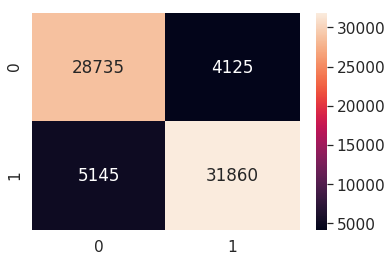

In [101]:
# now use other metrics to evaluate the prediction
# for direct multiclass
prediction = model2.predict(X_test)

finallabel= (prediction > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))

conf_mat = confusion_matrix(y_test, finallabel)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test, finallabel, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2 = np.where(prediction > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test, prediction2)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test,prediction2)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test,prediction2),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)


Test accuracy is 0.84625144811607
[[7233 1422]
 [1365 8107]]
Test accuracy is 0.84625144811607
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.84      0.84      0.84      8655
          Class 1:deletion       0.85      0.86      0.85      9472

               avg / total       0.85      0.85      0.85     18127

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.7343189717 1   0.67  0.96 4185 346 4470 9126
0.2 0.800022066531 1   0.75  0.93 5687 657 2968 8815
0.3 0.827163899156 1   0.79  0.90 6429 907 2226 8565
0.4 0.837038671595 1   0.82  0.88 6858 1157 1797 8315
0.5 0.846251448116 1   0.85  0.86 7233 1365 1422 8107
0.6 0.848292602196 1   0.87  0.83 7512 1607 1143 7865
0.7 0.847023776687 1   0.90  0.80 7765 1883 890 7589
0.8 0.841286478733 1   0.92  0.76 8038 2260 617 7212
0.9 0.820654272632 1   0.95  0.70 8278 2874 377 6598


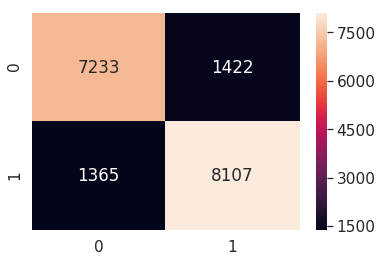

In [100]:
# testing on the set aside test data from ibc

predictiont2 = model2.predict(testX1)

finallabelt2= (predictiont2 > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))

conf_mat = confusion_matrix(y_test1, finallabelt2)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test1, finallabelt2, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2t = np.where(predictiont2 > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test1, prediction2t)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test1,prediction2t)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test1, prediction2t),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

#### C. using several CNN1d layers

In [66]:
epochs=3
batch_size=512
model3 = Sequential()
model3.add(Embedding(n_most_common_words, emb_dim, input_length=X_train.shape[1]))
model3.add(Conv1D(filters=128, kernel_size=4,activation='relu'))
model3.add(MaxPooling1D(pool_size=3))
model3.add(Dropout(0.25))
model3.add(Conv1D(filters=128, kernel_size=4,activation='relu'))
model3.add(MaxPooling1D(pool_size=3))
model3.add(Dropout(0.25))
model3.add(Conv1D(filters=64, kernel_size=4,activation='relu'))
model3.add(MaxPooling1D(pool_size=3))
model3.add(Dropout(0.25))
#model3.add(Conv1D(filters=128, kernel_size=5,activation='relu'))
#model3.add(MaxPooling1D(pool_size=15))
#model3.add(Dropout(0.25))
model3.add(Flatten())
#model3.add(Dense(32, activation='relu'))
#model3.add(LSTM(64, dropout=0.75, recurrent_dropout=0.75))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model3.summary())
#history3 = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history3a = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 128)           25600000  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 67, 128)           65664     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 22, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 19, 128)           65664     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 6, 128)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 128)            0         
__________

In [381]:
joblib.dump(model3, '../picklefolder_ngrams/DeleteReason_biclass_Mar2619_cnn1d.pickle')    
model3.save('../picklefolder_ngrams/DeleteReason_biclass_Mar2619_cnn1d_model.h5')

In [67]:
accr = model3.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = model3.evaluate(testX1,y_test1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69854/69854 [==============================] - 7s 104us/step
Test set
  Loss: 0.337
  Accuracy: 0.879
18127/18127 [==============================] - 2s 105us/step
Test set
  Loss: 0.439
  Accuracy: 0.846


69854/69854 [==============================] - 7s 104us/step
Test set
  Loss: 0.337
  Accuracy: 0.879


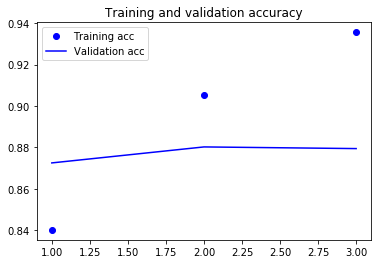

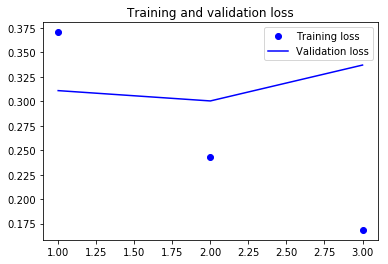

In [68]:
accr = model3.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
import matplotlib.pyplot as plt

acc = history3a.history['acc']
val_acc = history3a.history['val_acc']
loss = history3a.history['loss']
val_loss = history3a.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Test accuracy is 0.8277338896733623
[[106807  18841]
 [ 21784  88395]]
Test accuracy is 0.8277338896733623
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.83      0.85      0.84    125648
          Class 1:deletion       0.82      0.80      0.81    110179

                 micro avg       0.83      0.83      0.83    235827
                 macro avg       0.83      0.83      0.83    235827
              weighted avg       0.83      0.83      0.83    235827

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.76932666743  1   0.70  0.90 82358 11109 43290 99070
0.2 0.788306682441  1   0.73  0.87 89693 13968 35955 96211
0.3 0.821161275002  1   0.79  0.84 100647 17174 25001 93005
0.4 0.826029250255  1   0.81  0.82 104123 19502 21525 90677
0.5 0.827733889673  1   0.82  0.80 106807 21784 18841 88395
0.6 0.827246244069  1   0.84  0.78 109118 24210 16530 85969
0.7 0.824761371683  1   0.85  0.76 111287 26965 14361 83214

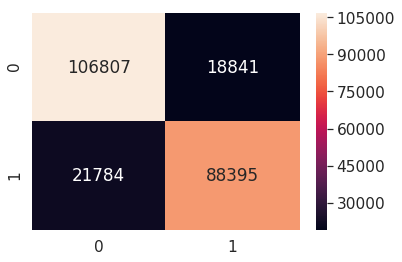

In [363]:
# now use other metrics to evaluate the prediction
# for direct multiclass
prediction = model3.predict(X_test)

finallabel= (prediction > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))

conf_mat = confusion_matrix(y_test, finallabel)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test, finallabel, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2 = np.where(prediction > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test, prediction2)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test,prediction2)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test,prediction2),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)


#### D. attention

In [69]:
from keras import initializers,regularizers,constraints
from keras.layers import * 

In [70]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [72]:
epochs=3
n_most_common_words=200000
batch_size=512
emb_dim=200
model4 = Sequential()
model4.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model4.add(LSTM(128, return_sequences=True))   #dropout=0.75, recurrent_dropout=0.75))
model4.add(LSTM(64, return_sequences=True))   #dropout=0.75, recurrent_dropout=0.75))
model4.add(Attention(X.shape[1]))

#model3.add(Conv1D(filters=128, kernel_size=5,activation='relu'))
#model3.add(MaxPooling1D(pool_size=15))
#model3.add(Dropout(0.25))
#model3.add(Flatten())
model4.add(Dense(64, activation='relu'))

model4.add(Dense(1, activation='sigmoid'))
#model3.add(Conv1D(filters=128, kernel_size=4,activation='relu'))
#model3.add(MaxPooling1D(pool_size=3))
#model3.add(Dropout(0.25))))
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model4.summary())
#history4 = model4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history4 = model4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 200)           40000000  
_________________________________________________________________
lstm_5 (LSTM)                (None, 70, 128)           168448    
_________________________________________________________________
lstm_6 (LSTM)                (None, 70, 64)            49408     
_________________________________________________________________
attention_2 (Attention)      (None, 64)                134       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 40,222,215
Trainable params: 40,222,215
Non-trainable params: 0
________________________________________________________________

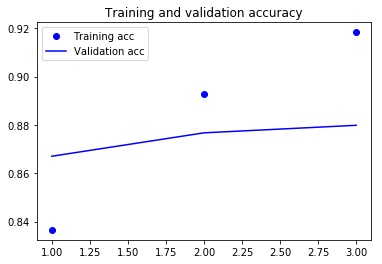

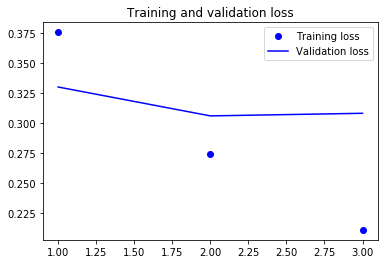

In [73]:
import matplotlib.pyplot as plt

acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
accr = model4.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = model4.evaluate(testX1,y_test1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69854/69854 [==============================] - 57s 817us/step
Test set
  Loss: 0.308
  Accuracy: 0.880
18127/18127 [==============================] - 15s 817us/step
Test set
  Loss: 0.402
  Accuracy: 0.847


Test accuracy is 0.8798350846050333
[[29372  3536]
 [ 4858 32088]]
Test accuracy is 0.8798350846050333
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.86      0.89      0.87     32908
          Class 1:deletion       0.90      0.87      0.88     36946

                 micro avg       0.88      0.88      0.88     69854
                 macro avg       0.88      0.88      0.88     69854
              weighted avg       0.88      0.88      0.88     69854

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.8135969307412604  1   0.75  0.96 21305 1418 11603 35528
0.2 0.860995791221691  1   0.83  0.93 25697 2499 7211 34447
0.3 0.8757694620207862  1   0.86  0.91 27557 3327 5351 33619
0.4 0.8799209780399118  1   0.88  0.89 28620 4100 4288 32846
0.5 0.8798350846050333  1   0.90  0.87 29372 4858 3536 32088
0.6 0.8768144988118075  1   0.92  0.85 30013 5710 2895 31236
0.7 0.871145532109829  1   0.93  0.82 30567 6660 2341 

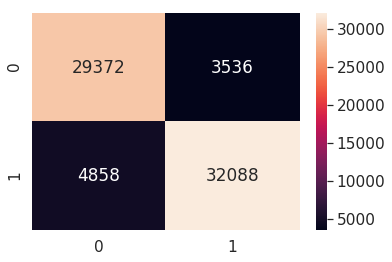

In [75]:
# now use other metrics to evaluate the prediction
# for direct multiclass
prediction = model4.predict(X_test)

finallabel= (prediction > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))

conf_mat = confusion_matrix(y_test, finallabel)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test, finallabel, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2 = np.where(prediction > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test, prediction2)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test,prediction2)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test,prediction2),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

Test accuracy is 0.8468031113808131
[[7243 1412]
 [1365 8107]]
Test accuracy is 0.8468031113808131
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.84      0.84      0.84      8655
          Class 1:deletion       0.85      0.86      0.85      9472

                 micro avg       0.85      0.85      0.85     18127
                 macro avg       0.85      0.85      0.85     18127
              weighted avg       0.85      0.85      0.85     18127

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.7638329563634357  1   0.70  0.95 4850 476 3805 8996
0.2 0.8153031389639764  1   0.77  0.92 6076 769 2579 8703
0.3 0.8342803552711425  1   0.81  0.90 6625 974 2030 8498
0.4 0.844706790974789  1   0.83  0.88 6981 1141 1674 8331
0.5 0.8468031113808131  1   0.85  0.86 7243 1365 1412 8107
0.6 0.8481822695426712  1   0.87  0.84 7459 1556 1196 7916
0.7 0.8457549511778011  1   0.88  0.81 7655 1796 1000 7676
0.8 0.842058807

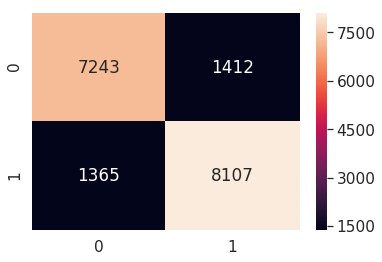

In [76]:
# testing on the set aside test data from ibc

predictiont2 = model4.predict(testX1)

finallabelt2= (predictiont2 > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))

conf_mat = confusion_matrix(y_test1, finallabelt2)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test1, finallabelt2, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2t = np.where(predictiont2 > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test1, prediction2t)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test1,prediction2t)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test1, prediction2t),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

#### using bidirectional LSTM in Attention network

In [77]:
epochs=3
model4a = Sequential()
model4a.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model4a.add(Bidirectional(LSTM(128, return_sequences=True)))   #dropout=0.75, recurrent_dropout=0.75))
model4a.add(Bidirectional(LSTM(64, return_sequences=True)))   #dropout=0.75, recurrent_dropout=0.75))
model4a.add(Attention(X.shape[1]))

#model3.add(Conv1D(filters=128, kernel_size=5,activation='relu'))
#model3.add(MaxPooling1D(pool_size=15))
#model3.add(Dropout(0.25))
#model3.add(Flatten())
model4a.add(Dense(64, activation='relu'))

model4a.add(Dense(1, activation='sigmoid'))
#model3.add(Conv1D(filters=128, kernel_size=4,activation='relu'))
#model3.add(MaxPooling1D(pool_size=3))
#model3.add(Dropout(0.25))))
model4a.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model4a.summary())
#history4a = model4a.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])
history4a = model4a.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 200)           40000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 70, 256)           336896    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 128)           164352    
_________________________________________________________________
attention_3 (Attention)      (None, 128)               198       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 40,509,767
Trainable params: 40,509,767
Non-trainable params: 0
________________________________________________________________

In [79]:
accr = model4a.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
accr = model4a.evaluate(testX1,y_test1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

69854/69854 [==============================] - 72s 1ms/step
Test set
  Loss: 0.320
  Accuracy: 0.882
18127/18127 [==============================] - 19s 1ms/step
Test set
  Loss: 0.427
  Accuracy: 0.846


In [119]:
#joblib.dump(model4, '../picklefolder_ngrams/DeleteReason_biclass_April0219_attention.pickle')   
#joblib.dump(model4a, '../picklefolder_ngrams/DeleteReason_biclass_April0219_attention.pickle')   
#model4.save('../picklefolder_ngrams/DeleteReason_biclass_Mar0619_attention_model.h5')

['../picklefolder_ngrams/DeleteReason_biclass_April0219_attention.pickle']

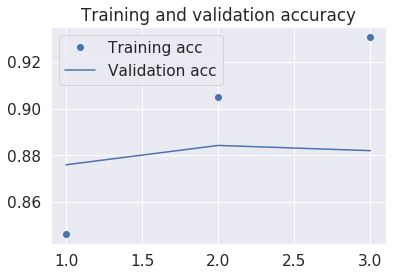

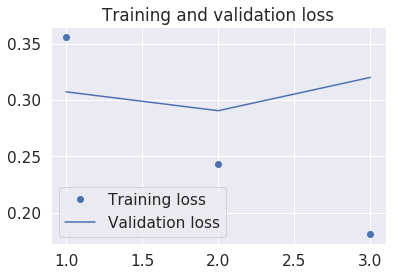

In [78]:
#accr = model4.evaluate(X_test,y_test)
#print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
import matplotlib.pyplot as plt

acc = history4a.history['acc']
val_acc = history4a.history['val_acc']
loss = history4a.history['loss']
val_loss = history4a.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Test accuracy is 0.8820110516219544
[[28783  4125]
 [ 4117 32829]]
Test accuracy is 0.8820110516219544
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.87      0.87      0.87     32908
          Class 1:deletion       0.89      0.89      0.89     36946

                 micro avg       0.88      0.88      0.88     69854
                 macro avg       0.88      0.88      0.88     69854
              weighted avg       0.88      0.88      0.88     69854

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.8203538809516993  1   0.76  0.96 21842 1483 11066 35463
0.2 0.8592349758066825  1   0.82  0.94 25341 2266 7567 34680
0.3 0.8730065565321957  1   0.85  0.92 26955 2918 5953 34028
0.4 0.8788902568213703  1   0.87  0.90 27961 3513 4947 33433
0.5 0.8820110516219544  1   0.89  0.89 28783 4117 4125 32829
0.6 0.8821971540641911  1   0.90  0.87 29420 4741 3488 32205
0.7 0.8805651788015003  1   0.92  0.85 29986 5421 292

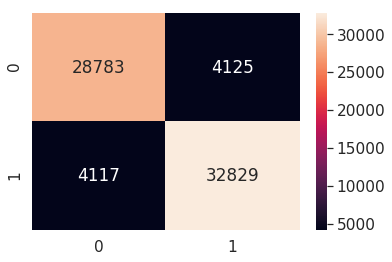

In [80]:
# now use other metrics to evaluate the prediction
# for direct multiclass
prediction = model4a.predict(X_test)

finallabel= (prediction > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))

conf_mat = confusion_matrix(y_test, finallabel)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test, finallabel)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test, finallabel, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2 = np.where(prediction > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test, prediction2)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test,prediction2)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test,prediction2),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)

Test accuracy is 0.8461962817895956
[[7095 1560]
 [1228 8244]]
Test accuracy is 0.8461962817895956
                            precision    recall  f1-score   support

Class 0:agreement+addition       0.85      0.82      0.84      8655
          Class 1:deletion       0.84      0.87      0.86      9472

                 micro avg       0.85      0.85      0.85     18127
                 macro avg       0.85      0.85      0.85     18127
              weighted avg       0.85      0.85      0.85     18127

threshold accuracy_score precision recall f1_score tn  fn  fp  tp
0.1 0.7689634247255476  1   0.71  0.95 4987 520 3668 8952
0.2 0.8124896563137861  1   0.77  0.92 6005 749 2650 8723
0.3 0.8313013736415292  1   0.80  0.90 6513 916 2142 8556
0.4 0.8392453246538313  1   0.82  0.89 6826 1085 1829 8387
0.5 0.8461962817895956  1   0.84  0.87 7095 1228 1560 8244
0.6 0.8513819164781817  1   0.86  0.86 7313 1352 1342 8120
0.7 0.8535885695371546  1   0.87  0.84 7498 1497 1157 7975
0.8 0.85369890

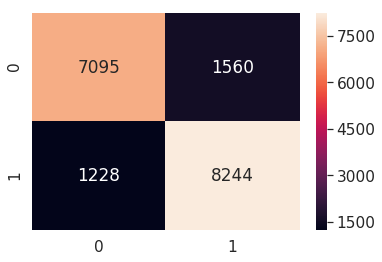

In [81]:
# testing on the set aside test data from ibc

predictiont2 = model4a.predict(testX1)

finallabelt2= (predictiont2 > 0.5).astype(np.int) 

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))

conf_mat = confusion_matrix(y_test1, finallabelt2)
print(conf_mat)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')

print('Test accuracy is {}'.format(accuracy_score(y_test1, finallabelt2)))
target_names = ['Class 0:agreement+addition', 'Class 1:deletion']
print(classification_report(y_test1, finallabelt2, target_names=target_names))

# now try different threshold
print("threshold accuracy_score precision recall f1_score tn  fn  fp  tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction2t = np.where(predictiont2 > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(y_test1, prediction2t)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(y_test1,prediction2t)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[3].split('     ')
    print(thres,accuracy_score(y_test1, prediction2t),row_data[2],row_data[3],row_data[4], tn, fn, fp, tp)
